In [2]:
import pandas as pd
import numpy as np
import pickle
from src.preprocessing.utils_preprocessing import PreProcessingPipe

Let's build the FAR and FRR and analyze the best threshold to use for this model

# FAR

We need the test dataset when those values are Fraud.

In [3]:
fraud_df = pd.read_csv("data/second-eda-output.csv")
fraud_df["day_of_month"] = fraud_df["day_of_month"].astype(str)

# Pre-processing Pipeline
pre_processing_pipe = PreProcessingPipe(dataset=fraud_df)
pre_processing_pipe.train_test_splitting(
    sample_test_size=0.40, to_drop=["is_fraud"]
)
pre_processing_pipe.one_hot_encoder(["day_of_month", "type"])

In [5]:
x_test = pre_processing_pipe.X_test
y_test = pre_processing_pipe.y_test

In [25]:
fraud_transformed_data = pd.concat([x_test, y_test], axis=1)
not_fraud_100 = fraud_transformed_data[fraud_transformed_data["is_fraud"] == 0].sample(100).drop(['is_fraud'], axis=1)

In [41]:
a = []
model_path = ["models/21_01_22_lr_w_v2.sav"]
# get 100 X_test, where we have just fraud=1, at random

with open(model_path[0], "rb") as f:
        model = pickle.load(f)

for i in range(100):
    # and get the probability of been fraud=0
    print(yhat_prob)
    class_index = yhat_class[0]
    print(class_index)
    class_probability = yhat_prob[0, class_index] * 100
    intp = int((class_probability))
    # print(f'Predicted: {intp} %')
    a.append(intp)



# class_probability = yhat_prob[0, cla]

[[5.78495605e-01 4.21504395e-01]
 [9.99999993e-01 7.17527069e-09]
 [9.99999647e-01 3.53335724e-07]
 [9.67172847e-01 3.28271535e-02]
 [1.70550692e-01 8.29449308e-01]
 [5.89042316e-01 4.10957684e-01]
 [9.99999993e-01 6.87166575e-09]
 [9.99999984e-01 1.60766549e-08]
 [9.99999990e-01 9.86252091e-09]
 [6.16307198e-01 3.83692802e-01]
 [9.99999993e-01 6.52156303e-09]
 [9.99999990e-01 1.04409101e-08]
 [9.38473459e-01 6.15265410e-02]
 [6.51525993e-01 3.48474007e-01]
 [9.99999983e-01 1.73476513e-08]
 [9.99999845e-01 1.55175531e-07]
 [9.99999985e-01 1.49729428e-08]
 [9.99999997e-01 3.35698052e-09]
 [9.99999923e-01 7.68035739e-08]
 [9.99999923e-01 7.65229715e-08]
 [9.99999990e-01 1.03981018e-08]
 [7.05569863e-01 2.94430137e-01]
 [6.23041278e-01 3.76958722e-01]
 [9.99999824e-01 1.75893373e-07]
 [9.99999991e-01 8.79128011e-09]
 [9.99999827e-01 1.72921907e-07]
 [9.99999912e-01 8.78975968e-08]
 [6.13557173e-01 3.86442827e-01]
 [9.99999981e-01 1.94427048e-08]
 [9.99092117e-01 9.07882563e-04]
 [9.999998

0

In [52]:
# far
yhat_class = model.predict(not_fraud_100)
yhat_prob = model.predict_proba(not_fraud_100)
probs = list(yhat_prob[:, 1]*100)
probs_int = [int(prob) for prob in probs]
probs_int

[42,
 0,
 0,
 3,
 82,
 41,
 0,
 0,
 0,
 38,
 0,
 0,
 6,
 34,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 29,
 37,
 0,
 0,
 0,
 0,
 38,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 34,
 46,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 23,
 0,
 0,
 0,
 40,
 45,
 0,
 0,
 25,
 4,
 30,
 0,
 0,
 0,
 21,
 0,
 35,
 0,
 0,
 10,
 2,
 0,
 0,
 0,
 0,
 45,
 0,
 0,
 41,
 0,
 0,
 0,
 0,
 0,
 0,
 12,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 19,
 41,
 0,
 0,
 4,
 87,
 44,
 50,
 0,
 0]

In [53]:
# apply the threshold and save how many observations passes
far = []
threshold = []
for i in range(100):
    num = 0
    for value in probs_int:
        if value > i:
            num += 1
    far.append(num)
    threshold.append(i)

far = np.array(far)
far

array([33, 33, 32, 31, 28, 28, 27, 27, 27, 27, 26, 26, 24, 24, 24, 24, 24,
       24, 24, 23, 23, 22, 22, 21, 21, 20, 20, 20, 20, 19, 18, 18, 18, 18,
       16, 15, 15, 14, 12, 12, 11,  8,  7,  7,  6,  4,  3,  3,  3,  3,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  1,  1,
        1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

# FRR

In [58]:
fraud_transformed_data = pd.concat([x_test, y_test], axis=1)
fraud_100_w_hat = fraud_transformed_data[fraud_transformed_data["is_fraud"] == 1].sample(100)
fraud_100 = fraud_100_w_hat.drop(['is_fraud'], axis=1)


In [75]:
yhat_class = model.predict(fraud_100)
yhat_prob = model.predict_proba(fraud_100)
probs = list(yhat_prob[:, 1]*100)
probs_int = [int(prob) for prob in probs]
# probs_int = [yhat for i, yhat in enumerate(yhat_class) if fraud_100_w_hat.values[i] == yhat]
probs_real_int = []
for i, yhat in enumerate(yhat_class):
    if fraud_100_w_hat["is_fraud"].values[i] == yhat:
        probs_real_int.append(probs_int[i]) 

len(probs_real_int)

91

In [76]:
frr = []
for i in range(100):
        num = 0

        for x in probs_real_int:
                if x<i:
                        num+=1
        #print(i,num)
        frr.append(num)


frr = np.array(frr)
frr

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  2,  2,  3,  3,  5,  5,  6,  6,  6,  6,  6,  8,  8,  8,
        9,  9,  9, 10, 11, 11, 12, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15,
       17, 18, 18, 18, 19, 20, 21, 22, 23, 25, 26, 31, 36, 37, 40])

In [84]:
import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams["figure.dpi"] = 200

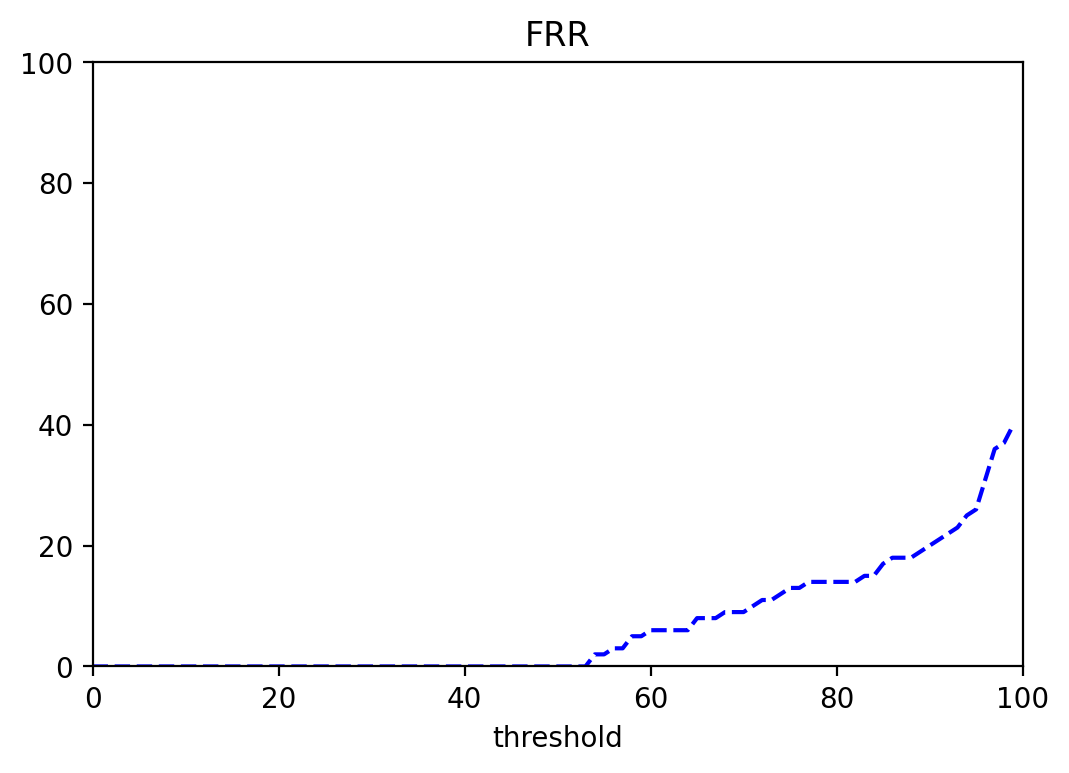

In [85]:
plt.plot(threshold,frr,'--b')
plt.xlabel('threshold')
plt.title('FRR')
plt.axis([0, 100, 0, 100])
plt.show()


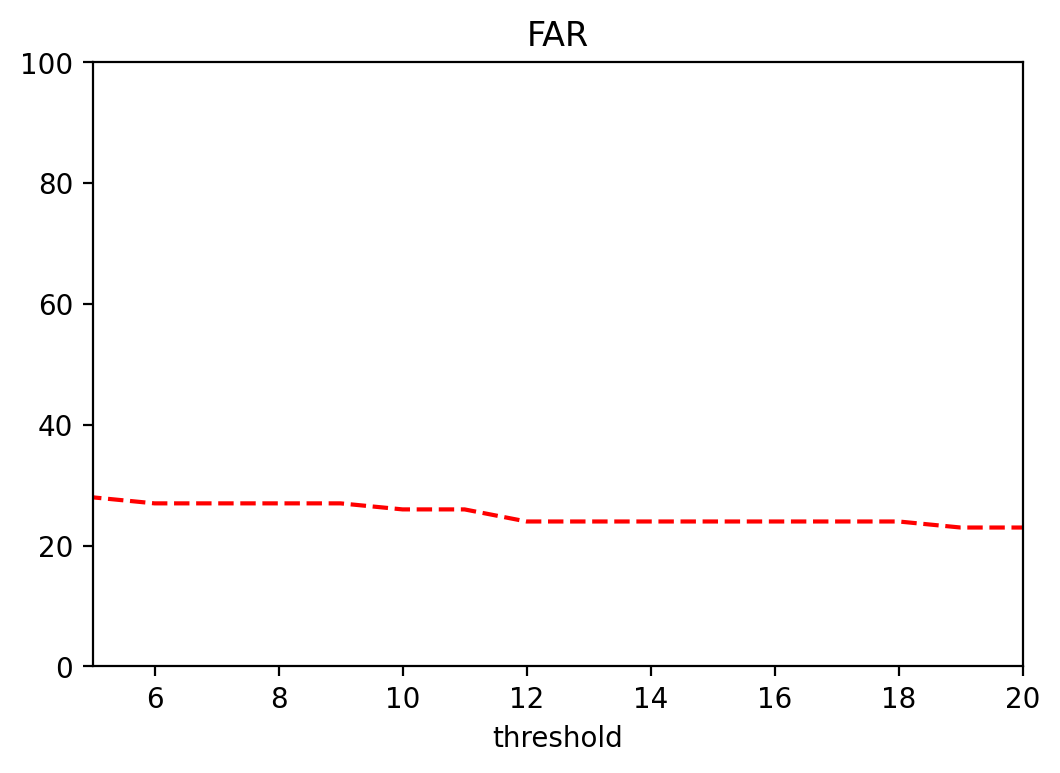

In [86]:
plt.plot(threshold,far,'--r')
plt.xlabel('threshold')
plt.title('FAR')

plt.axis([5, 20, 0, 100])
plt.show()

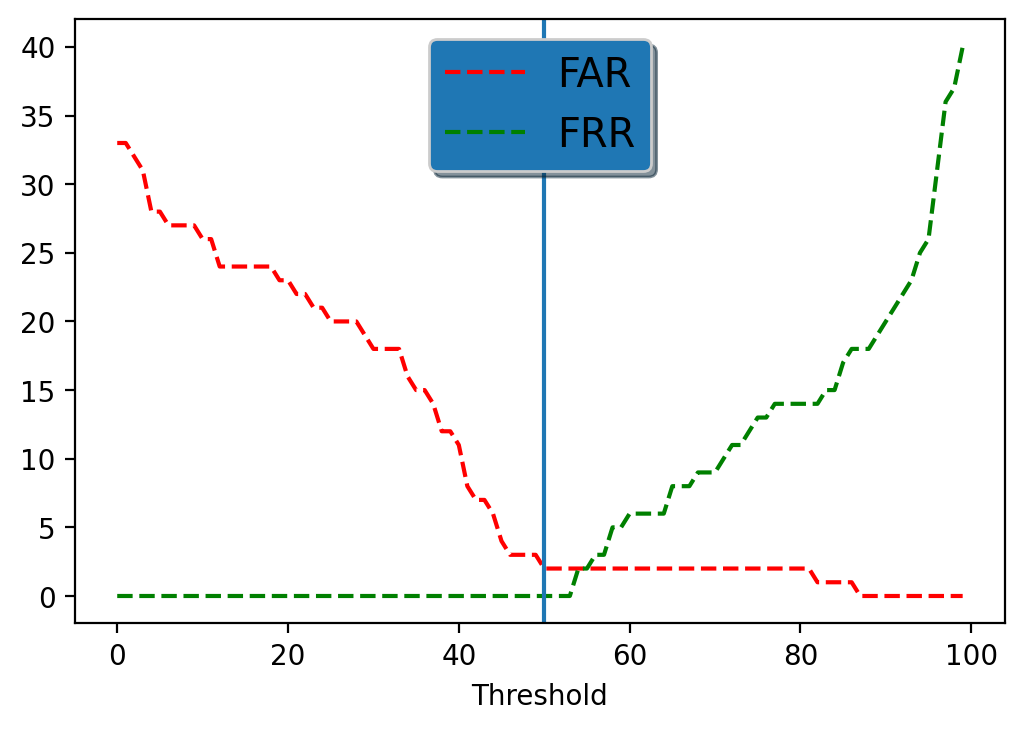

In [87]:
fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.axvline(x=50, ymin=0, ymax=40)

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()